In [8]:
# Load necessary libraries
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("lme4")) install.packages("lme4")
if (!require("janitor")) install.packages("janitor")
if (!require("readxl")) install.packages("readxl")
 
library(tidyverse)
library(readxl)
library(lme4)
library(lmerTest)
library(dplyr)
library(stringr)
library(readr)
library(ggplot2)
library(janitor)
library(conflicted)

In [27]:
# Load datasets
hiv_data_raw <- read_csv("C:/Users/Administrator/Downloads/internship_task_dscience-main/internship_task_dscience-main/HIV data 2000-2023.csv")
glimpse(hiv_data_raw)

Rows: 1552 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): IndicatorCode, Indicator, ValueType, ParentLocationCode, ParentLoc...
dbl  (1): Period

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,552
Columns: 11
$ IndicatorCode       <chr> "HIV_0000000001", "HIV_0000000001", "HIV_000000000…
$ Indicator           <chr> "Estimated number of people (all ages) living with…
$ ValueType           <chr> "numeric", "numeric", "numeric", "numeric", "numer…
$ ParentLocationCode  <chr> "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "…
$ ParentLocation      <chr> "Africa", "Africa", "Africa", "Africa", "Africa", …
$ `Location type`     <chr> "Country", "Country", "Country", "Country", "Count…
$ SpatialDimValueCode <chr> "AGO", "AGO", "AGO", "AGO", "AGO", "AGO", "AGO", "…
$ Location            <chr> "Angola", "Angola", "Angola", "Angola", "Angola", …
$ `Period type`       <chr> "Year", "Year", "Year", "Year", "Year", "Year", "Y…
$ Period              <dbl> 2023, 2022, 2021, 2020, 2015, 2010, 2005, 2000, 20…
$ Value               <chr> "320 000 [280 000 - 380 000]", "320 000 [280 000 -…


In [33]:
hiv_data <- hiv_data_raw %>%
  mutate(
    Value_clean = str_extract(Value, "^[0-9 ]+"),    
    Value_clean = as.numeric(gsub(" ", "", Value_clean))  
  ) %>%
  select(
    Country = Location, 
    Year = Period, 
    Value = Value_clean,
    ParentLocationCode,   
    ParentLocation        
  )
# Check cleaned HIV data
glimpse(hiv_data)


Rows: 1,552
Columns: 5
$ Country            <chr> "Angola", "Angola", "Angola", "Angola", "Angola", "…
$ Year               <dbl> 2023, 2022, 2021, 2020, 2015, 2010, 2005, 2000, 202…
$ Value              <dbl> 320000, 320000, 320000, 320000, 300000, 250000, 190…
$ ParentLocationCode <chr> "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "A…
$ ParentLocation     <chr> "Africa", "Africa", "Africa", "Africa", "Africa", "…


In [34]:
# Sum HIV cases globally by year
global_hiv <- hiv_data %>%
  group_by(Year) %>%
  summarise(global_total = sum(Value, na.rm = TRUE))


In [35]:
# Calculate cumulative contribution for each country
hiv_cumulative <- hiv_data %>%
  group_by(Country) %>%
  summarise(total_cases = sum(Value, na.rm = TRUE)) %>%
  arrange(desc(total_cases)) %>%
  mutate(cum_percent = cumsum(total_cases) / sum(total_cases) * 100)

top_countries <- hiv_cumulative %>%
  filter(cum_percent <= 75 | row_number() == 1) %>%   
  pull(Country)

# Filter HIV dataset for top countries
hiv_top_countries <- hiv_data %>%
  filter(Country %in% top_countries)

hiv_top_countries$Year <- as.numeric(hiv_top_countries$Year)


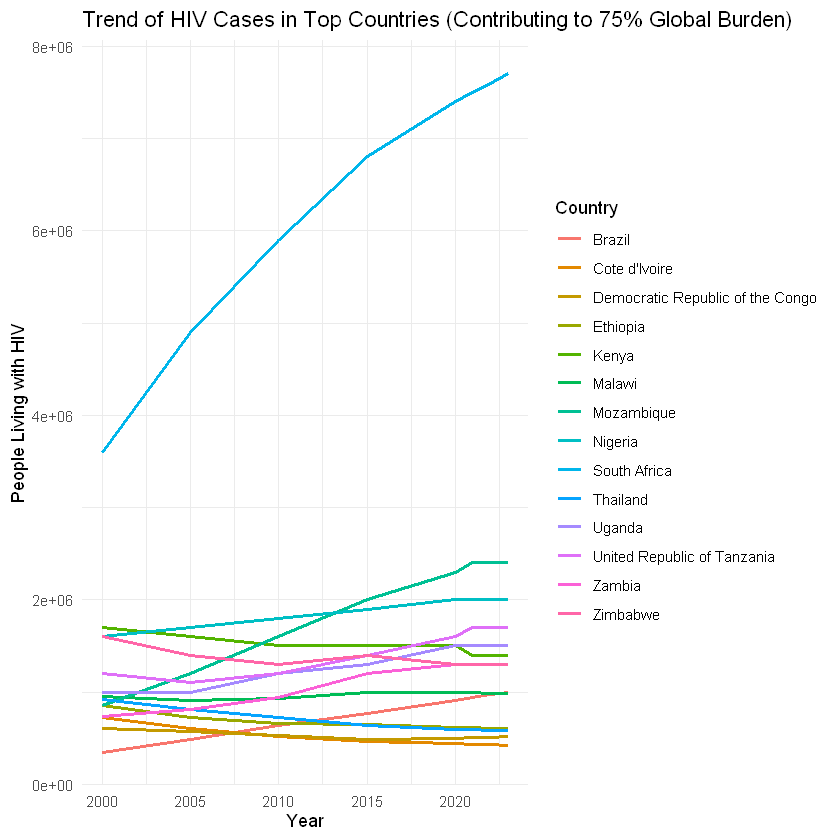

In [37]:
# Plot trend
ggplot(hiv_top_countries, aes(x = Year, y = Value, color = Country)) +
  geom_line(linewidth = 1) +
  labs(title = "Trend of HIV Cases in Top Countries (Contributing to 75% Global Burden)",
       y = "People Living with HIV",
       x = "Year",
       color = "Country") +
  theme_minimal()


In [39]:
hiv_region_top <- hiv_data %>%
  group_by(ParentLocationCode, Country) %>%
  summarise(total_cases = sum(Value, na.rm = TRUE), .groups = "drop_last") %>%
  arrange(ParentLocationCode, desc(total_cases)) %>%
  mutate(region_total = sum(total_cases),
         cum_percent = cumsum(total_cases) / region_total * 100) %>%
  filter(cum_percent <= 75)


In [40]:
# Filter HIV dataset for these countries
hiv_region_countries <- hiv_data %>%
  semi_join(hiv_region_top, by = c("ParentLocationCode", "Country"))


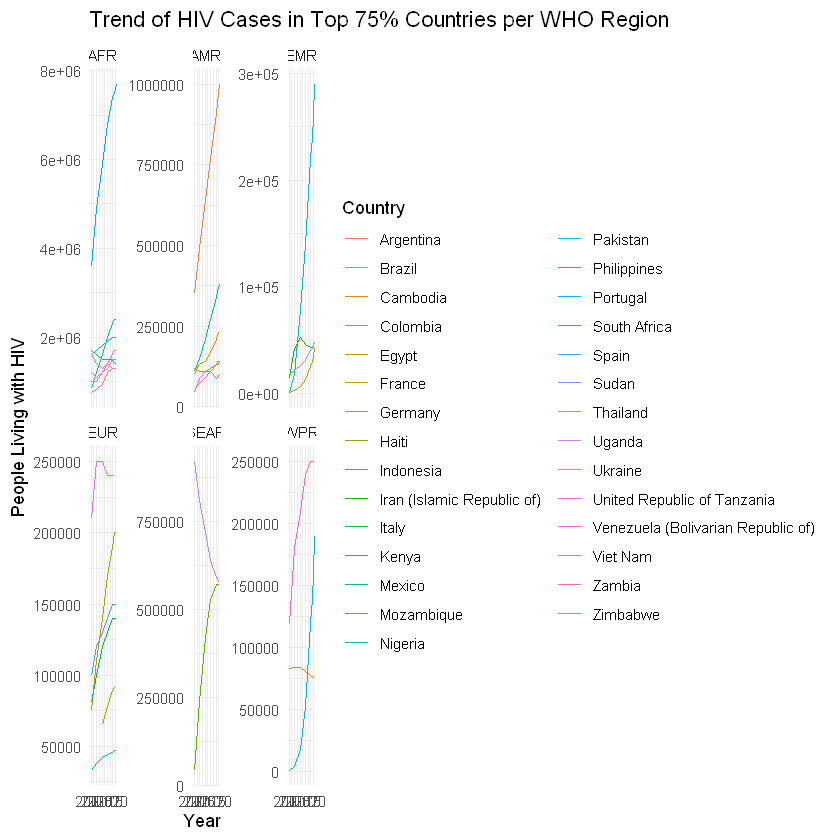

In [42]:
hiv_region_countries_clean <- hiv_region_countries %>%
  filter(!is.na(Value))

ggplot(hiv_region_countries_clean, aes(x = Year, y = Value, color = Country)) +
  geom_line() +
  facet_wrap(~ ParentLocationCode, scales = "free_y") +
  labs(title = "Trend of HIV Cases in Top 75% Countries per WHO Region",
       y = "People Living with HIV",
       x = "Year") +
  theme_minimal()


In [66]:
# Load the poverty data 
poverty_raw <- read_excel("C:/Users/Administrator/Downloads/internship_task_dscience-main/internship_task_dscience-main/multidimensional_poverty.xlsx")


glimpse(poverty_raw)
head(poverty_raw)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`


Rows: 112
Columns: 16
$ `Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023)\r\nDate: October 2024` <chr> …
$ ...2                                                                                                                     <chr> …
$ ...3                                                                                                                     <chr> …
$ ...4                                                                                                                     <chr> …
$ ...5                                                                                                                     <chr> …
$ ...6                                                                                                                     <chr> …
$ ...7                                                                                                                     <chr> …
$ ...8                                                       

"Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023) Date: October 2024",...2,...3,...4,...5,...6,...7,...8,...9,...10,...11,...12,...13,...14,...15,...16
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),NA,NA,NA,NA,NA,Multidimensional poverty headcount ratio (%)
NA,NA,NA,NA,NA,NA,NA,NA,NA,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NA
SSA,AGO,Angola,2018,IDREA,2018,N,c,2,31.122004985809298,29.7534227371215,27.443060278892499,52.639532089233398,53.637516498565596,32.106507280141003,47.203606367111199
ECA,ALB,Albania,2012,HBS,2018,N,c,1,4.8107048496603903E-2,0.192380091175436,-,6.0250010574236498E-2,6.5797723829746202,9.5949657452627903,0.29316141735762302
LAC,ARG,Argentina,2010,EPHC-S2,2021,U,i,3,0.89421793818473794,1.0853196494281201,0.73135080747306302,0,0.25745299644768199,0.36404800517942798,0.906572956591844
ECA,ARM,Armenia,2010,ILCS,2021,N,c,1,0.52352081984281496,0,1.7930038273334499,0,0.39772549644112498,0.66008218894200898,0.52352081984281496


In [67]:
colnames(poverty_raw)

[1] "Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023)\r\nDate: October 2024"
 [2] "...2"                                                                                                                  
 [3] "...3"                                                                                                                  
 [4] "...4"                                                                                                                  
 [5] "...5"                                                                                                                  
 [6] "...6"                                                                                                                  
 [7] "...7"                                                                                                                  
 [8] "...8"                                                                                                                  
 [9] "...9"                                                                                                                  
[10] "...10"                                                                                                                 
[11] "...11"                                                                                                                 
[12] "...12"                                                                                                                 
[13] "...13"                                                                                                                 
[14] "...14"                                                                                                                 
[15] "...15"                                                                                                                 
[16] "...16"

In [69]:

poverty_raw <- read_excel(
  "C:/Users/Administrator/Downloads/internship_task_dscience-main/internship_task_dscience-main/multidimensional_poverty.xlsx",
  skip = 1  
)


names(poverty_raw)
head(poverty_raw)

New names:
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`


[1] "Region"                                      
 [2] "Country code"                                
 [3] "Economy"                                     
 [4] "Reporting year"                              
 [5] "Survey name"                                 
 [6] "Survey year"                                 
 [7] "Survey coverage"                             
 [8] "Welfare type"                                
 [9] "Survey comparability"                        
[10] "Deprivation rate (share of population)"      
[11] "...11"                                       
[12] "...12"                                       
[13] "...13"                                       
[14] "...14"                                       
[15] "...15"                                       
[16] "Multidimensional poverty headcount ratio (%)"

Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),...11,...12,...13,...14,...15,Multidimensional poverty headcount ratio (%)
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NA
SSA,AGO,Angola,2018,IDREA,2018,N,c,2,31.122004985809298,29.7534227371215,27.443060278892499,52.639532089233398,53.637516498565596,32.106507280141003,47.2036064
ECA,ALB,Albania,2012,HBS,2018,N,c,1,4.8107048496603903E-2,0.192380091175436,-,6.0250010574236498E-2,6.5797723829746202,9.5949657452627903,0.2931614
LAC,ARG,Argentina,2010,EPHC-S2,2021,U,i,3,0.89421793818473794,1.0853196494281201,0.73135080747306302,0,0.25745299644768199,0.36404800517942798,0.9065730
ECA,ARM,Armenia,2010,ILCS,2021,N,c,1,0.52352081984281496,0,1.7930038273334499,0,0.39772549644112498,0.66008218894200898,0.5235208
EAP,AUS,Australia,2010,SIH-LIS,2018,N,I,3,0.516879977658391,1.71188004314899,-,0,0,-,2.2157701


In [70]:
# Standardize column names 
poverty_clean <- poverty_raw %>%
  clean_names()  

# cleaned names
names(poverty_clean)

[1] "region"                                          
 [2] "country_code"                                    
 [3] "economy"                                         
 [4] "reporting_year"                                  
 [5] "survey_name"                                     
 [6] "survey_year"                                     
 [7] "survey_coverage"                                 
 [8] "welfare_type"                                    
 [9] "survey_comparability"                            
[10] "deprivation_rate_share_of_population"            
[11] "x11"                                             
[12] "x12"                                             
[13] "x13"                                             
[14] "x14"                                             
[15] "x15"                                             
[16] "multidimensional_poverty_headcount_ratio_percent"

In [76]:
colnames(poverty_clean)

[1] "region"                                          
 [2] "country_code"                                    
 [3] "country"                                         
 [4] "year"                                            
 [5] "survey_name"                                     
 [6] "survey_year"                                     
 [7] "survey_coverage"                                 
 [8] "welfare_type"                                    
 [9] "survey_comparability"                            
[10] "poverty_value"                                   
[11] "x11"                                             
[12] "x12"                                             
[13] "x13"                                             
[14] "x14"                                             
[15] "x15"                                             
[16] "multidimensional_poverty_headcount_ratio_percent"

In [77]:
poverty_final <- poverty_clean %>%
  select(
    region,
    country_code,
    country,
    year,
    poverty_headcount = multidimensional_poverty_headcount_ratio_percent,
    deprivation_rate = poverty_value
  ) %>%
  filter(!is.na(country) & country != "")

# Verify
glimpse(poverty_final)
head(poverty_final)

Rows: 110
Columns: 6
$ region            <chr> "SSA", "ECA", "LAC", "ECA", "EAP", "ECA", "SSA", "EC…
$ country_code      <chr> "AGO", "ALB", "ARG", "ARM", "AUS", "AUT", "BDI", "BE…
$ country           <chr> "Angola", "Albania", "Argentina", "Armenia", "Austra…
$ year              <dbl> 2018, 2012, 2010, 2010, 2010, 2009, 2013, 2009, 2015…
$ poverty_headcount <dbl> 47.20360637, 0.29316142, 0.90657296, 0.52352082, 2.2…
$ deprivation_rate  <chr> "31.122004985809298", "4.8107048496603903E-2", "0.89…


region,country_code,country,year,poverty_headcount,deprivation_rate
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
SSA,AGO,Angola,2018,47.2036064,31.122004985809298
ECA,ALB,Albania,2012,0.2931614,4.8107048496603903E-2
LAC,ARG,Argentina,2010,0.9065730,0.89421793818473794
ECA,ARM,Armenia,2010,0.5235208,0.52352081984281496
EAP,AUS,Australia,2010,2.2157701,0.516879977658391
ECA,AUT,Austria,2009,0.6622446,0.48582218587398501


In [79]:
# Check HIV data columns
names(hiv_data)

# Check poverty data columns
names(poverty_final)

[1] "Country"            "Year"               "Value"             
[4] "ParentLocationCode" "ParentLocation"

[1] "region"            "country_code"      "country"          
[4] "year"              "poverty_headcount" "deprivation_rate"

In [82]:
glimpse(merged_data)

# Check merge success rate
merged_data %>%
  summarise(
    matched = mean(!is.na(poverty_headcount)),
    unmatched = mean(is.na(poverty_headcount))
  )

Rows: 1,552
Columns: 9
$ Country            <chr> "Angola", "Angola", "Angola", "Angola", "Angola", "…
$ Year               <dbl> 2023, 2022, 2021, 2020, 2015, 2010, 2005, 2000, 202…
$ Value              <dbl> 320000, 320000, 320000, 320000, 300000, 250000, 190…
$ ParentLocationCode <chr> "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "AFR", "A…
$ ParentLocation     <chr> "Africa", "Africa", "Africa", "Africa", "Africa", "…
$ region             <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ country_code       <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ poverty_headcount  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ deprivation_rate   <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…


matched,unmatched
<dbl>,<dbl>
0.02706186,0.9729381


In [16]:
colnames(merged_data)


[1] "IndicatorCode"                "Indicator"                   
 [3] "ValueType"                    "ParentLocationCode"          
 [5] "ParentLocation"               "Location type"               
 [7] "SpatialDimValueCode"          "Location"                    
 [9] "Period type"                  "Period"                      
[11] "Value"                        "RegionCode"                  
[13] "CountryCode"                  "Country"                     
[15] "Year"                         "IDREA"                       
[17] "Year.1"                       "N"                           
[19] "c"                            "Deprivation Score"           
[21] "Income Deprivation"           "Education Deprivation"       
[23] "School Enrolment Deprivation" "Electricity Deprivation"     
[25] "Sanitation Deprivation"       "Drinking Water Deprivation"  
[27] "Housing Deprivation"

In [26]:
# filter globally
conflicts_prefer(dplyr::filter)

# Load merged data directly from CSV
merged_data <- read_csv("merged_hiv_poverty.csv")

# Count observations per country
merged_data %>% 
  count(Country) %>% 
  print(n = Inf)

# Clean data
cleaned_data <- merged_data %>%
  filter(!is.na(Value) & !is.na(`Income Deprivation`) & !is.na(Country) & !is.na(Year))

# Check levels of 'Country' and 'Year' after cleaning
cat("Levels in 'Country' factor:\n")
print(table(cleaned_data$Country))

cat("Levels in 'Year' factor:\n")
print(table(cleaned_data$Year))


cleaned_data <- cleaned_data %>%
  mutate(
    `Income Deprivation` = as.numeric(`Income Deprivation`),
    Value = as.numeric(Value),
    Country = factor(Country),
    Year = factor(Year)
  )


cat("Number of levels in 'Country': ", nlevels(cleaned_data$Country), "\n")
cat("Number of levels in 'Year': ", nlevels(cleaned_data$Year), "\n")

if(nlevels(cleaned_data$Country) <= 1) {
  cat("'Country' has only one level. Removing 'Country' from the model.\n")
  cleaned_data <- cleaned_data %>% select(-Country)
}

if(nlevels(cleaned_data$Year) <= 1) {
  cat("'Year' has only one level. Removing 'Year' from the model.\n")
  cleaned_data <- cleaned_data %>% select(-Year)
}

# Check the number of rows after cleaning
cat("Number of rows after cleaning: ", nrow(cleaned_data), "\n")


cat("Checking if 'Income Deprivation' and 'Value' are constant...\n")
cat("Unique values in 'Income Deprivation': ", length(unique(cleaned_data$`Income Deprivation`)), "\n")
cat("Unique values in 'Value': ", length(unique(cleaned_data$Value)), "\n")


if(length(unique(cleaned_data$`Income Deprivation`)) == 1) {
  cleaned_data <- cleaned_data %>% select(-`Income Deprivation`)
  cat("'Income Deprivation' had only one unique value, so it has been removed.\n")
}
if(length(unique(cleaned_data$Value)) == 1) {
  cleaned_data <- cleaned_data %>% select(-Value)
  cat("'Value' had only one unique value, so it has been removed.\n")
}


cat("Running fixed-effects model...\n")
final_model <- lm(Value ~ `Income Deprivation` + Country + Year, data = cleaned_data)

# Display model summary
summary(final_model)



[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.
Rows: 42 Columns: 27
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (20): IndicatorCode, Indicator, ValueType, ParentLocationCode, ParentLoc...
dbl  (7): Period, Year, Year.1, Deprivation Score, Income Deprivation, Educa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 42 × 2
   Country                n
   <chr>              <int>
 1 Argentina              1
 2 Armenia                1
 3 Australia              1
 4 Bangladesh             1
 5 Belarus                1
 6 Benin                  1
 7 Colombia               1
 8 Costa Rica             1
 9 Cote d'Ivoire          1
10 Croatia                1
11 Dominican Republic     1
12 Ecuador                1
13 El Salvador            1
14 Georgia                1
15 Germany                1
16 Guinea-Bissau          1
17 Honduras               1
18 Israel                 1
19 Kazakhstan             1
20 Kenya                  1
21 Malawi                 1
22 Mexico                 1
23 Mongolia               1
24 Nepal                  1
25 North Macedonia        1
26 Pakistan               1
27 Panama                 1
28 Paraguay               1
29 Peru                   1
30 Poland                 1
31 Romania                1
32 Russian Federation     1
33 Serbia                 1
3

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion"


Number of levels in 'Country':  42 
Number of levels in 'Year':  3 
Number of rows after cleaning:  42 
Checking if 'Income Deprivation' and 'Value' are constant...
Unique values in 'Income Deprivation':  40 
Unique values in 'Value':  1 
'Value' had only one unique value, so it has been removed.
Running fixed-effects model...


ERROR: Error in eval(predvars, data, env): object 'Value' not found
